No internal model, no spoofing action available

In [6]:
name='Experiment00'

In [7]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from UCLSE.dyna_q.Experiment1a import Experiment
from UCLSE.dyna_q.dyna_q import TabularMemory
from UCLSE.dyna_q.benchmarking import BenchmarkAgent, SpoofAgent, DoNothing
import numpy as np
import pandas as pd
import os
import torch
import visdom
import matplotlib.pyplot as plt

In [9]:
vis=visdom.Visdom(port=8097)

In [10]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
            ans+=-1 #penalty
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why

In [11]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':6000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':False,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,10))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

action_list={0:(0,0,0), #do nothing 
         1:(-1,1,-1) #add ask at best bid (hit the bid)
        }


lobenv_kwargs={'cutoff':100,'profit_target':10,'loss_limit':-1,'reward_func':reward_oracle,'lamb':0.5,'action_list':action_list}
agent_kwargs={'CVAE':False,'env_H1Size':16,'env_H2Size':16,'Q_H1Size':16,'Q_H2Size':16,'loss_func':None}


In [12]:
dyna_config={
	"batch_size": 64,
	"learning_rate": 5e-3,
	"exploration": {
		"type": "exponential",
		"init_epsilon": 0.8,
		"min_epsilon": 0.05,
		"decay_steps": 100000,
		"decay_eps": 0.99,
        "choice":'least_bonus'
	},
	"memory": {
		"memory_capacity": 1000000,
		"prioritized": False,
        "tabular memory":True,
        
	},
	"discount": 0.99,
	"target_update_freq": 50,
	"first_update": 200,
	"modify_reward": False,
    "learn":'Q',
    'double_q_model':True,
    'model_update_freq':5,
    'planning_freq':5}

In [13]:
experiment=Experiment(trader_pref_kwargs=trader_pref_kwargs,timer_kwargs=timer_kwargs,
           price_sequence_kwargs=price_sequence_kwargs,noise_kwargs=noise_kwargs,
           messenger_kwargs=messenger_kwargs,env_kwargs=env_kwargs,trader_kwargs=trader_kwargs,
           lobenv_kwargs=lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,dyna_kwargs=dyna_config,name=name)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory


In [14]:
experiment.new_train_setup(MaxEpisodes=1000,planning_steps=0,lookback=20,thresh=3,planning=False,graph=True)

In [15]:
experiment.train(MaxEpisodes=10001,start_episode=experiment.episode,folder='Results/'+experiment.name)

Planning is False, double Q model is True, tabular memory is True
Dyna-Q - EXP: 1 | Ep: 21 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.0
Dyna-Q - EXP: 1 | Ep: 41 | timestep: 2 | Ep_r:  0.0 Profit: -3 Avg loss:0.01225125
Dyna-Q - EXP: 1 | Ep: 61 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.0
Saving best checkpoint at episode 65 with reward 0
not strict double Q model
making new directory Results/Experiment00
Dyna-Q - EXP: 1 | Ep: 81 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.012375
Dyna-Q - EXP: 1 | Ep: 101 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.012375
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 121 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.012375
Saving best checkpoint at episode 131 with reward 0.012375
not strict double Q model
Dyna-Q - E

Saving best checkpoint at episode 990 with reward 0.46982650747004995
not strict double Q model
Dyna-Q - EXP: 1 | Ep: 1001 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.350968699622367
Saving checkpoint at episode 1000
not strict double Q model
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 1021 | timestep: 7 | Ep_r:  0.995 Profit: 0 Avg loss:0.15798206088086242
Dyna-Q - EXP: 1 | Ep: 1041 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:-0.0009827725124749997
Dyna-Q - EXP: 1 | Ep: 1061 | timestep: 9 | Ep_r:  0.0 Profit: -1 Avg loss:0.11584366764506329
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 1081 | timestep: 42 | Ep_r:  2.115281326721968 Profit: 1 Avg loss:0.3488676037145787
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 1101 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.1526781197336559
sequence made
adding exchange to RL trader  

Saving checkpoint at episode 2000
not strict double Q model
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 2021 | timestep: 25 | Ep_r:  -0.009751995000000013 Profit: -1 Avg loss:-0.004691048650426838
Dyna-Q - EXP: 1 | Ep: 2041 | timestep: 5 | Ep_r:  0.99005 Profit: 0 Avg loss:0.09878662271453019
Dyna-Q - EXP: 1 | Ep: 2061 | timestep: 2 | Ep_r:  0.995 Profit: 0 Avg loss:0.44492264075447147
copying eval net to target net
Saving best checkpoint at episode 2071 with reward 0.6075651459426662
not strict double Q model
Dyna-Q - EXP: 1 | Ep: 2081 | timestep: 9 | Ep_r:  0.995 Profit: 0 Avg loss:0.48066827850157756
Dyna-Q - EXP: 1 | Ep: 2101 | timestep: 30 | Ep_r:  0.8889106796995733 Profit: 0 Avg loss:0.08904695430418982
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net


Dyna-Q - EXP: 1 | Ep: 3001 | timestep: 26 | Ep_r:  0.0 Profit: -1 Avg loss:0.3867915904485725
Saving checkpoint at episode 3000
not strict double Q model
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3021 | timestep: 10 | Ep_r:  0.0 Profit: -1 Avg loss:0.08771823636063485
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 3041 | timestep: 21 | Ep_r:  0.0 Profit: -1 Avg loss:0.6266332264849921
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 3061 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.33271716780251026
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3081 | timestep: 5 | Ep_r:  0.0 Profit: -1 Avg loss:0.057260732226770805
Dyna-Q - EXP: 1 | Ep: 3101 | timestep: 19 | Ep_r:  -0.9851494999999999 Profit: -2 Avg loss:-0.10349819065395582
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3

adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4041 | timestep: 17 | Ep_r:  0.0 Profit: -1 Avg loss:0.24075923218446152
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4061 | timestep: 26 | Ep_r:  1.9039534687986155 Profit: 1 Avg loss:0.19986351948384176
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4081 | timestep: 22 | Ep_r:  -0.017998112242336474 Profit: -1 Avg loss:0.2527138254731991
Dyna-Q - EXP: 1 | Ep: 4101 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.33622938635978716
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4121 | timestep: 2 | Ep_r:  0.0 Profit: -1 Avg loss:0.669950394932235
Dyna-Q - EXP: 1 | Ep: 4141 | timestep: 8 | Ep_r:  -2.0 Profit: -3 Avg loss:-0.09683702871460823
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to R

Dyna-Q - EXP: 1 | Ep: 5061 | timestep: 11 | Ep_r:  0.0 Profit: -1 Avg loss:0.43148283418931366
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5081 | timestep: 2 | Ep_r:  0.0 Profit: -1 Avg loss:0.14833023290130354
Dyna-Q - EXP: 1 | Ep: 5101 | timestep: 35 | Ep_r:  1.9462350996505 Profit: 1 Avg loss:0.529768110425669
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5121 | timestep: 32 | Ep_r:  -1.8968071418218275 Profit: -3 Avg loss:0.0513300475097066
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 5141 | timestep: 27 | Ep_r:  1.1164010043425845 Profit: 1 Avg loss:0.3962212163917954
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 5161 | timestep: 36 | Ep_r:  -0.9371073813402392 Profit: -2 Avg loss:0.4403265582530779
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 5181 | timestep: 9 | Ep_

Dyna-Q - EXP: 1 | Ep: 6101 | timestep: 8 | Ep_r:  0.995 Profit: 0 Avg loss:0.24084979832342518
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6121 | timestep: 6 | Ep_r:  0.980298005 Profit: 34 Avg loss:0.14334756911487317
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6141 | timestep: 6 | Ep_r:  0.0 Profit: -1 Avg loss:0.22028204479371855
Dyna-Q - EXP: 1 | Ep: 6161 | timestep: 6 | Ep_r:  -0.980298005 Profit: -2 Avg loss:0.2823351685405811
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6181 | timestep: 19 | Ep_r:  1.9607900747004998 Profit: 1 Avg loss:0.06029796334289324
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6201 | timestep: 3 | Ep_r:  0.0 Profit: -1 Avg loss:-0.31138397123929995
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6221 | timestep: 11 | Ep_r:  0.0 Profit: -1 Avg 

Dyna-Q - EXP: 1 | Ep: 7121 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.3669552165444509
Dyna-Q - EXP: 1 | Ep: 7141 | timestep: 26 | Ep_r:  0.0 Profit: -1 Avg loss:0.3663510094101676
Dyna-Q - EXP: 1 | Ep: 7161 | timestep: 32 | Ep_r:  -0.9089534687986154 Profit: -2 Avg loss:-0.10962425322750298
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7181 | timestep: 18 | Ep_r:  0.9613723472139599 Profit: 0 Avg loss:0.12151807391927574
Dyna-Q - EXP: 1 | Ep: 7201 | timestep: 89 | Ep_r:  2.546261071727088 Profit: 2 Avg loss:0.26399364339208214
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 7221 | timestep: 15 | Ep_r:  -2.0 Profit: -3 Avg loss:0.0772495698561996
Dyna-Q - EXP: 1 | Ep: 7241 | timestep: 17 | Ep_r:  0.0 Profit: -1 Avg loss:-0.096783989

Dyna-Q - EXP: 1 | Ep: 8141 | timestep: 29 | Ep_r:  0.0 Profit: -1 Avg loss:0.01443401930642027
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8161 | timestep: 34 | Ep_r:  0.17763830681807302 Profit: -1 Avg loss:0.4354572034747125
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8181 | timestep: 13 | Ep_r:  0.9851494999999999 Profit: 0 Avg loss:0.2807517621472148
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8201 | timestep: 10 | Ep_r:  0.0 Profit: -1 Avg loss:-0.0003972053285420274
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 8221 | timestep: 10 | Ep_r:  -0.004754950249500004 Profit: -1 Avg loss:0.08320975211924396
Dyna-Q - EXP: 1 | Ep: 8241 | timestep: 75 | Ep_r:  0.7876773749884642 Profit: 0 Avg loss:0.6177317215868608
Dyna-Q - EXP: 1 | Ep: 8261 | timestep: 22 | Ep_r:  -1.913084311917

Dyna-Q - EXP: 1 | Ep: 9161 | timestep: 7 | Ep_r:  0.0 Profit: -1 Avg loss:0.23117175025555245
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9181 | timestep: 2 | Ep_r:  0.0 Profit: -1 Avg loss:0.2963936210675988
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9201 | timestep: 55 | Ep_r:  1.792045875742859 Profit: 1 Avg loss:0.6468888087454323
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9221 | timestep: 9 | Ep_r:  0.0 Profit: -1 Avg loss:0.30228679260439917
Dyna-Q - EXP: 1 | Ep: 9241 | timestep: 23 | Ep_r:  0.0 Profit: -3 Avg loss:0.010513575369309002
Dyna-Q - EXP: 1 | Ep: 9261 | timestep: 10 | Ep_r:  0.9707400747004999 Profit: 0 Avg loss:-0.04966426420050903
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9281 | timestep: 9 | Ep_r:  0.995 Profit: 0 Avg los

In [16]:
experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment00\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment00\dyna_best.pth.tar' (epoch 7453)
not double Q
keys unused in checkpoint data:  ['episode', 'setup']


In [17]:
experiment.agent.set_device('cpu')

Device in use is  cpu


In [22]:
experiment.test_setup(MaxEpisodes=5000)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory
Dyna-Q - EXP 1, | Ep: , 1, | timestep:  1 | Ep_r: 0.0|profit:-1 start:269|end:270
r0 0.5
Dyna-Q - EXP 1, | Ep: , 11, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1295|end:1296
r0 1.0
r0 0.5
Dyna-Q - EXP 1, | Ep: , 21, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2369|end:2370
Dyna-Q - EXP 1, | Ep: , 31, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3471|end:3472
Dyna-Q - EXP 1, | Ep: , 41, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4534|end:4535
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 51, | timestep:  1 | Ep_r: 0.0|profit:-1 start:539|end:540
Dyna-Q - EXP 1, | Ep: , 61, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1613|end:1614
Dyna-Q - EXP 1, | Ep: , 71, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2724|end:2725
Dyna-Q - EXP 1, | Ep: , 81, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3823|end:3824
sequence made
a

Dyna-Q - EXP 1, | Ep: , 771, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4796|end:4797
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 781, | timestep:  1 | Ep_r: 0.0|profit:-1 start:906|end:907
Dyna-Q - EXP 1, | Ep: , 791, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2566|end:2567
Dyna-Q - EXP 1, | Ep: , 801, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3955|end:3956
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 811, | timestep:  1 | Ep_r: 0.0|profit:-1 start:38|end:39
r0 0.5
Dyna-Q - EXP 1, | Ep: , 821, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1248|end:1249
Dyna-Q - EXP 1, | Ep: , 831, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2520|end:2521
Dyna-Q - EXP 1, | Ep: , 841, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3703|end:3704
Dyna-Q - EXP 1, | Ep: , 851, | timestep:  1 | Ep_r: 0.0|profit:-1 start:5008|end:5009
sequence made
adding exchange to RL trader  RL
adding exch

adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1531, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1194|end:1195
Dyna-Q - EXP 1, | Ep: , 1541, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2317|end:2318
Dyna-Q - EXP 1, | Ep: , 1551, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3764|end:3765
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1561, | timestep:  1 | Ep_r: 0.0|profit:-1 start:249|end:250
Dyna-Q - EXP 1, | Ep: , 1571, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1285|end:1286
Dyna-Q - EXP 1, | Ep: , 1581, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2562|end:2563
Dyna-Q - EXP 1, | Ep: , 1591, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3982|end:3983
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1601, | timestep:  1 | Ep_r: 0.0|profit:-1 start:603|end:604
Dyna-Q - EXP 1, | Ep: , 1611, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2003|end:2004
Dyna-Q - EXP 1, | Ep: , 1621

Dyna-Q - EXP 1, | Ep: , 2291, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2667|end:2668
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2301, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3875|end:3876
Dyna-Q - EXP 1, | Ep: , 2311, | timestep:  1 | Ep_r: 0.0|profit:-1 start:5006|end:5007
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2321, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1206|end:1207
Dyna-Q - EXP 1, | Ep: , 2331, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2414|end:2415
Dyna-Q - EXP 1, | Ep: , 2341, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3484|end:3485
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2351, | timestep:  1 | Ep_r: 0.0|profit:-1 start:5012|end:5013
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2361, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1413|end:1414
Dyna-Q - EXP 1, | Ep: , 2371, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2781|end:2782
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2381, | time

Dyna-Q - EXP 1, | Ep: , 3051, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3609|end:3610
Dyna-Q - EXP 1, | Ep: , 3061, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4848|end:4849
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3071, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1052|end:1053
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3081, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2314|end:2315
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3091, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3689|end:3690
Dyna-Q - EXP 1, | Ep: , 3101, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4728|end:4729
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3111, | timestep:  1 | Ep_r: 0.2475|profit:0 start:641|end:642
Dyna-Q - EXP 1, | Ep: , 3121, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1688|end:1689
Dyna-Q - EXP 1, | Ep: , 3131, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2799|end:2800
Dyna-Q - EXP 1, | Ep: , 3141,

Dyna-Q - EXP 1, | Ep: , 3801, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2738|end:2739
Dyna-Q - EXP 1, | Ep: , 3811, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4079|end:4080
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3821, | timestep:  1 | Ep_r: 0.0|profit:-1 start:134|end:135
Dyna-Q - EXP 1, | Ep: , 3831, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1183|end:1184
Dyna-Q - EXP 1, | Ep: , 3841, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2370|end:2371
Dyna-Q - EXP 1, | Ep: , 3851, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3481|end:3482
Dyna-Q - EXP 1, | Ep: , 3861, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4904|end:4905
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3871, | timestep:  1 | Ep_r: 0.0|profit:-1 start:935|end:936
Dyna-Q - EXP 1, | Ep: , 3881, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2192|end:2193
Dyna-Q - EXP 1, | Ep: , 3891, | timestep:  1 | Ep_r: 0

Dyna-Q - EXP 1, | Ep: , 4551, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3084|end:3085
Dyna-Q - EXP 1, | Ep: , 4561, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4677|end:4678
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 1.0
Dyna-Q - EXP 1, | Ep: , 4571, | timestep:  1 | Ep_r: 0.0|profit:-1 start:963|end:964
Dyna-Q - EXP 1, | Ep: , 4581, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2031|end:2032
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4591, | timestep:  1 | Ep_r: 0.0|profit:-1 start:3276|end:3277
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4601, | timestep:  1 | Ep_r: 0.0|profit:-1 start:4380|end:4381
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4611, | timestep:  1 | Ep_r: 0.0|profit:-1 start:459|end:460
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4621, | timestep:  1 | Ep_r: 0.0|profit:-1 start:1479|end:1480
Dyna-Q - EXP 1, | Ep: , 4631, | timestep:  1 | Ep_r: 0.0|profit:-1 start:2725|end:2726
r0 0.5
Dyna-Q - EXP 1, | E

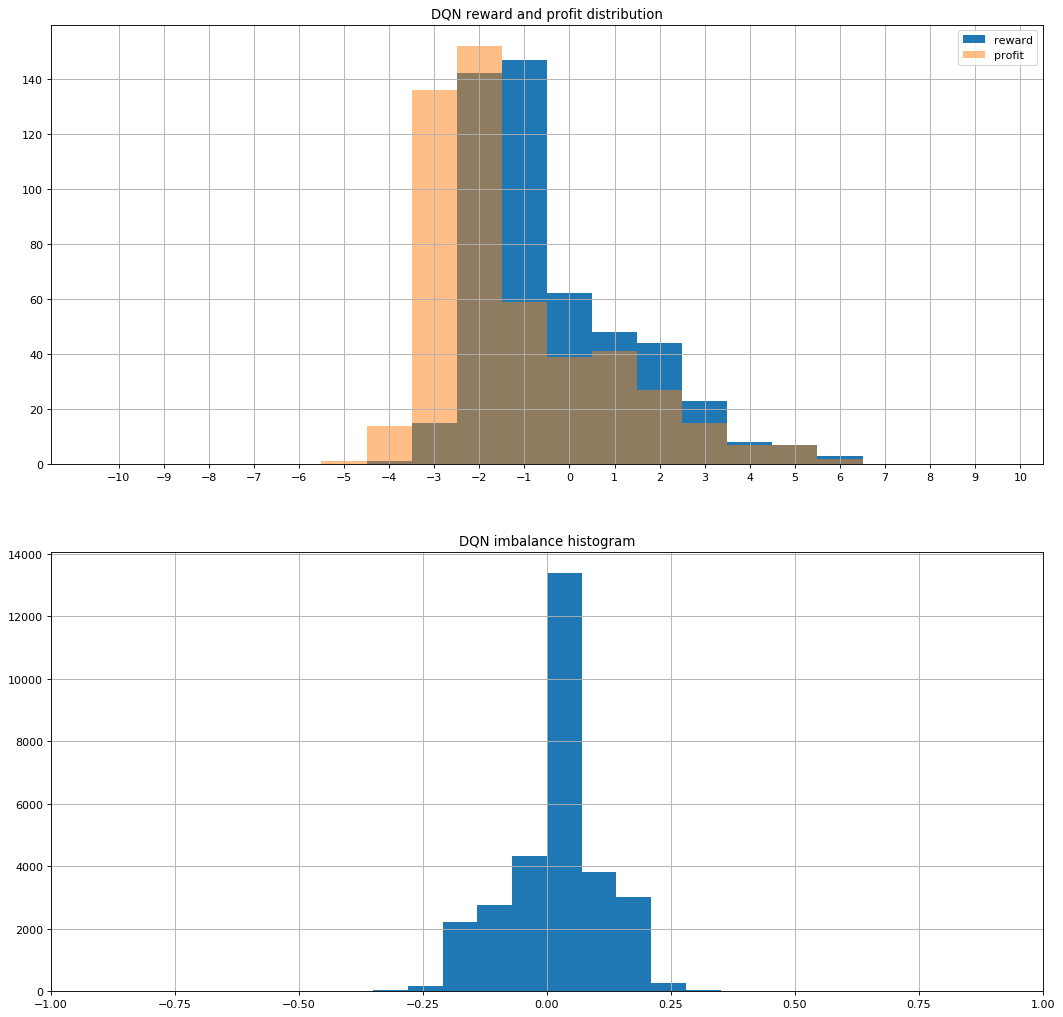

In [19]:
path='Results'
d,memory=experiment.plotbm_results(experiment,'DQN reward and profit distribution',
                                   'DQN imbalance histogram',name=experiment.name,path=path)

In [20]:
d.describe()

,reward,profit,start distance,duration
count,500.000000,500.000000,500.000000,500.000000
mean,-0.400053,-1.234000,0.097600,60.226000
std,1.779943,2.012796,0.017745,37.046509
min,-4.000000,-5.000000,-0.100000,1.000000
25%,-1.926080,-3.000000,0.100000,24.750000
50%,-0.995000,-2.000000,0.100000,61.000000
75%,0.696629,0.000000,0.100000,100.000000
max,5.886039,6.000000,0.100000,100.000000


In [21]:
memory.n_inventory.value_counts(), memory.action.value_counts()

(1.0    29954
 0.0      159
 Name: n_inventory, dtype: int64, 0.0    29954
 1.0      159
 Name: action, dtype: int64)